In [4]:
import numpy as np
import matplotlib.pyplot as plt
import jax 
from jax import vmap

In [5]:
import jax.numpy as jnp
from flax import nnx
from functools import partial

rngs = nnx.Rngs(0)

class AutoEncoder(nnx.Module):
    
    def __init__(self, rngs: nnx.Rngs):
    
        # define number of image channels
        self.n_channels = 3

        # define quantization
        self.K = 17

        # complexity of model 
        n_features = 32
        kernel_size = (3, 3)
        c_strides = (1, 1)
        p_strides = (2, 2)
        padding = 'SAME'
        self.activation = nnx.tanh
        self.do = nnx.Dropout(0., rngs=rngs)
        
        # Downsampling

        # pooling operation
        self.pool = partial(nnx.max_pool, window_shape=(2, 2), strides=p_strides, padding=padding)

        # convolutional layers
        self.conv1a = nnx.Conv(self.n_channels, n_features, 
                               kernel_size=kernel_size, 
                               padding=padding, 
                               strides=c_strides,
                               rngs=rngs)
        self.conv1b = nnx.Conv(n_features, n_features, 
                               kernel_size=kernel_size, 
                               padding=padding, 
                               strides=c_strides,
                               rngs=rngs)
        
        self.conv2a = nnx.Conv(n_features, 2 * n_features, 
                               kernel_size=kernel_size, 
                               padding=padding, 
                               strides=c_strides,
                               rngs=rngs)
        self.conv2b = nnx.Conv(2 * n_features, 2 * n_features, 
                               kernel_size=kernel_size, 
                               padding=padding, 
                               strides=c_strides,
                               rngs=rngs)

        # Bottleneck
        # self.bottle1 = nnx.Conv(2 * n_features, 4 * n_features, 
        #                        kernel_size=kernel_size, 
        #                        padding=padding, 
        #                        strides=c_strides,
        #                        rngs=rngs)
        # self.bottle2 = nnx.Conv(4 * n_features, 4 * n_features, 
        #                         kernel_size=kernel_size, 
        #                         padding=padding, 
        #                         strides=c_strides,
        #                         rngs=rngs)

        # Compression
        self.compress = nnx.Conv(2 * n_features, n_features // 2, 
                                 kernel_size=kernel_size, 
                                 padding=padding, 
                                 strides=c_strides,
                                 rngs=rngs)
        # self.decompress = nnx.Conv(n_features // 4, 4 * n_features, 
        #                            kernel_size=kernel_size, 
        #                            padding=padding, 
        #                            strides=c_strides,
        #                            rngs=rngs)
        
        # Upsampling
        self.upconv1 = nnx.ConvTranspose(n_features // 2, 2 * n_features, 
                                         kernel_size=kernel_size, 
                                         padding=padding, 
                                         strides=p_strides, 
                                         rngs=rngs)
        
        self.outconv1a = nnx.Conv(2 * n_features, 2 * n_features, 
                                  kernel_size=kernel_size, 
                                  padding=padding, 
                                  strides=c_strides,
                                  rngs=rngs)
        self.outconv1b = nnx.Conv(2 * n_features, 2 * n_features, 
                                  kernel_size=kernel_size, 
                                  padding=padding, 
                                  strides=c_strides,
                                  rngs=rngs)
          
        self.upconv2 = nnx.ConvTranspose(2 * n_features, n_features, 
                                         kernel_size=kernel_size, 
                                         padding=padding, 
                                         strides=p_strides, 
                                         rngs=rngs)
        
        self.outconv2a = nnx.Conv(n_features, n_features, 
                                  kernel_size=kernel_size, 
                                  padding=padding, 
                                  strides=c_strides, 
                                  rngs=rngs)
        self.outconv2b = nnx.Conv(n_features, n_features, 
                                  kernel_size=kernel_size, 
                                  padding=padding, 
                                  strides=c_strides, 
                                  rngs=rngs)

        # Final
        self.outconv3 = nnx.Conv(n_features, self.K * self.n_channels, kernel_size=(1, 1), rngs=rngs)
    
    def convnet(self, x, conv):

        # activation over convolution
        return self.do(self.activation(conv(x)))
    
    def resnet(self, x, conv):

        # activation over convolution with residual connection
        return x + self.convnet(x, conv)
    
    def __call__(self, x):

        # encoder
        
        # n_channels -> n_features 
        x = self.resnet(self.convnet(x, self.conv1a), self.conv1b)
        
        # n_features -> 2 * n_features 
        x = self.resnet(self.convnet(self.pool(x), self.conv2a), self.conv2b)

        # 2 * n_features -> 4 * n_features 
        # x = self.resnet(self.convnet(self.pool(x), self.bottle1), self.bottle2)

        # compression
        x = self.convnet(self.pool(x), self.compress)
        # x = self.convnet(x, self.decompress)
        
        # upsample
        x = self.upconv1(x)
        
        # 2 * 2 * n_features -> 2 * n_features 
        x = self.resnet(self.resnet(x, self.outconv1a), self.outconv1b)

        # upsample
        x = self.upconv2(x)
    
        # 2 * n_features -> n_features 
        x = self.resnet(self.resnet(x, self.outconv2a), self.outconv2b)
        
        # n_features -> n_channels 
        x = self.outconv3(x)

        # reshape and softmax
        B, H, W, KC = x.shape
        x = jnp.reshape(x, [B, H, W, self.n_channels, self.K])

        return x

    def encode(self, x):

        # encoder
        
        # n_channels -> n_features 
        x = self.resnet(self.convnet(x, self.conv1a), self.conv1b)
        
        # n_features -> 2 * n_features 
        x = self.resnet(self.convnet(self.pool(x), self.conv2a), self.conv2b)

        # 2 * n_features -> 4 * n_features 
        # x = self.resnet(self.convnet(self.pool(x), self.bottle1), self.bottle2)

        # compression
        x = self.convnet(self.pool(x), self.compress)
        
        return x

    def decode(self, x):
        
        # upsample
        x = self.upconv1(x)
        
        # 2 * 2 * n_features -> 2 * n_features 
        x = self.resnet(self.resnet(x, self.outconv1a), self.outconv1b)

        # upsample
        x = self.upconv2(x)
    
        # 2 * n_features -> n_features 
        x = self.resnet(self.resnet(x, self.outconv2a), self.outconv2b)
        
        # n_features -> n_channels 
        x = self.outconv3(x)

        # reshape and softmax
        B, H, W, KC = x.shape
        x = jnp.reshape(x, [B, H, W, self.n_channels, self.K])

        return x

# Initialize the model
autoencoder = AutoEncoder(rngs)

### Import data

In [6]:
# load data
import cv2
import os

# define quantization
filters = np.array([0,  16,  32,  48,  64,  80,  96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 255])
K = len(filters)

# returns one-hot-encoded array of shape [img.shape] + [filters.shape]
def filter_img(img, filters):

    # assign filter values to pixels 
    pixel_diff = vmap(lambda low_pix: (low_pix - img) ** 2)
    return filters[np.argmin(pixel_diff(filters), 0)]

# returns one-hot-encoded array of shape [img.shape] + [filters.shape]
def one_hot_encode(img, filters):

    # assign filter values to pixels 
    f = filter_img(img, filters)

    # one-hot-encode image 
    pixel_eq = lambda low_pix: jnp.array(f == low_pix, int)

    # use numpy array to keep data on CPU 
    return np.array(vmap(pixel_eq, in_axes=0, out_axes=-1)(filters))

# data set of roses
img_size = 128
X = []
Y = []
for fname in os.listdir("data/roses/"):
    img = cv2.imread(f"data/roses/{fname}")
    img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_AREA)

    # append input and output data
    X.append(img)
    Y.append(one_hot_encode(img, filters))
    
    # Create the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D((img_size // 2, img_size // 2), 90, scale=1.)
    
    # Perform the rotation
    img = cv2.warpAffine(img, rotation_matrix, (img_size, img_size))
    
    # append input and output data
    X.append(img)
    Y.append(one_hot_encode(img, filters))
    
    # Create the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D((img_size // 2, img_size // 2), 90, scale=1.)
    
    # Perform the rotation
    img = cv2.warpAffine(img, rotation_matrix, (img_size, img_size))

    # append input and output data
    X.append(img)
    Y.append(one_hot_encode(img, filters))

X = np.stack(X)
Y = np.stack(Y)

# number of samples
N = len(X)

# random shuffling of sample index
order = np.arange(N)
np.random.shuffle(order)

In [7]:
np.mean(X)

np.float64(96.96852740486311)

In [8]:
np.std(X)

np.float64(77.34616179770855)

In [9]:
# standardize data
X = (X - np.mean(X)) / np.std(X)

### Initialize optimizer

In [59]:
import optax
from optax import softmax_cross_entropy

learning_rate = 0.001
weight_decay = .0001

optimizer = nnx.Optimizer(autoencoder, optax.adamw(learning_rate, weight_decay=weight_decay))
metrics = nnx.MultiMetric(loss=nnx.metrics.Average('loss'),)

### Define cost function

In [5]:
def loss_fn(model: AutoEncoder, X_batch, Y_batch):
    
    # predict input
    Y_pred = model(X_batch)

    # return cross entropy loss
    loss = softmax_cross_entropy(Y_pred, Y_batch).mean()
    
    return loss

In [6]:
@nnx.jit
def train_step(model: AutoEncoder, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, X_batch, Y_batch):
    """Train for a single step."""
    grad_fn = nnx.value_and_grad(loss_fn)
    loss, grads = grad_fn(model, X_batch, Y_batch)
    metrics.update(loss=loss)
    optimizer.update(grads)

### Train

In [60]:
# define training parameters

# number of training epochs
n_epochs = 50

# batch size
n_batch = 16

In [61]:
# keep track of training loss
loss = []

# train over epochs (using dropout)
autoencoder.train() 
for epoch in range(n_epochs):

    # random shuffling of sample index
    np.random.shuffle(order)
    
    # loop over baches of data
    for batch_inds in np.array_split(order, np.ceil(N / n_batch)):

        # get data batch
        X_batch = X[batch_inds]
        Y_batch = Y[batch_inds]

        # take step
        train_step(autoencoder, optimizer, metrics, X_batch, Y_batch)

    # print progress
    for metric, value in metrics.compute().items():
        loss.append(value)
        print(f"Epoch {epoch+1}", metric, value)
autoencoder.eval()

Epoch 1 loss 0.51237696
Epoch 2 loss 0.5101836
Epoch 3 loss 0.5091089
Epoch 4 loss 0.5083486
Epoch 5 loss 0.5074616
Epoch 6 loss 0.506665
Epoch 7 loss 0.50596565
Epoch 8 loss 0.5053008
Epoch 9 loss 0.50474626
Epoch 10 loss 0.5041977
Epoch 11 loss 0.5037184
Epoch 12 loss 0.50335574
Epoch 13 loss 0.5028922
Epoch 14 loss 0.5024726
Epoch 15 loss 0.5021121
Epoch 16 loss 0.5017897
Epoch 17 loss 0.5014275
Epoch 18 loss 0.5010901
Epoch 19 loss 0.50077033
Epoch 20 loss 0.5004282
Epoch 21 loss 0.5001365
Epoch 22 loss 0.4998667
Epoch 23 loss 0.49962685
Epoch 24 loss 0.49940073
Epoch 25 loss 0.49914098
Epoch 26 loss 0.49888265
Epoch 27 loss 0.4986252
Epoch 28 loss 0.4983932
Epoch 29 loss 0.49815613
Epoch 30 loss 0.4979449
Epoch 31 loss 0.49775007
Epoch 32 loss 0.4975455
Epoch 33 loss 0.4973409
Epoch 34 loss 0.4971318
Epoch 35 loss 0.49693197
Epoch 36 loss 0.4967417
Epoch 37 loss 0.49655858
Epoch 38 loss 0.496373
Epoch 39 loss 0.49620214
Epoch 40 loss 0.49603808
Epoch 41 loss 0.49589777
Epoch 42 lo

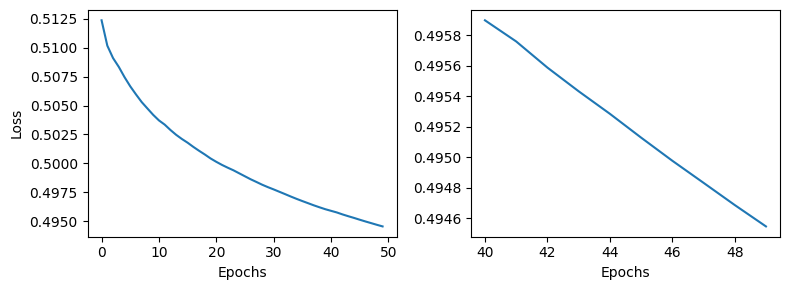

In [62]:
plt.figure(figsize=(8, 3))
plt.subplot(1,2,1)
plt.plot(np.array(loss)) # [-500:])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(np.arange(len(loss)-10, len(loss)), np.array(loss)[-10:])
plt.xlabel("Epochs")
# plt.ylabel("Loss")
plt.tight_layout()
plt.show()

In [63]:
# example image
sample = 0
x = X[sample]
y = filters[np.argmax(Y[sample], -1)]

# predicted
y_pred = autoencoder(x[jnp.newaxis,...])[0]
y_pred = filters[np.argmax(nnx.softmax(y_pred, -1), -1)]

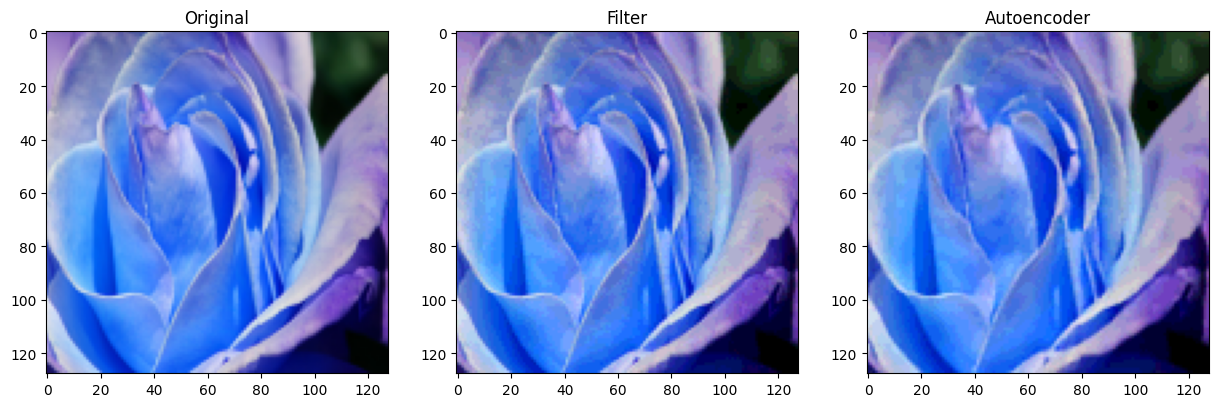

In [64]:
# plot comparison
plt.figure(figsize=(5*3, 5))
plt.subplot(1, 3, 1)
plt.imshow((x - np.min(x))/(np.max(x)-np.min(x)))
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(y)
plt.title("Filter")

plt.subplot(1, 3, 3)
plt.imshow(y_pred)
plt.title("Autoencoder")

plt.show()

In [10]:
# returns one-hot-encoded array of shape [img.shape] + [filters.shape]
def filter_img(img, filters):

    # assign filter values to pixels 
    pixel_diff = vmap(lambda low_pix: (low_pix - img) ** 2)
    return filters[np.argmin(pixel_diff(filters), 0)]

# returns one-hot-encoded array of shape [img.shape] + [filters.shape]
def one_hot_encode(img, filters):

    # assign filter values to pixels 
    f = filter_img(img, filters)

# data set of roses
img_size = 256
Xbig = []
Ybig = []
for fname in os.listdir("data/roses_test/"):
    img = cv2.imread(f"data/roses_test/{fname}")
    img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_AREA)

    # append input and output data
    Xbig.append(img)
    Ybig.append(filter_img(img, filters))
Xbig = np.stack(Xbig)
Ybing = np.stack(Ybig)

In [68]:
# example image
x = Xbig[2]
y = Ybig[2]
# x = cv2.resize(cv2.imread("data/apple.jpg"), (img_size, img_size), interpolation=cv2.INTER_AREA)
# y = filter_img(x, filters)
# x = (x - np.mean(x)) / np.std(x)

# predicted
y_pred = autoencoder(x[jnp.newaxis,...])[0]
y_pred = filters[jnp.argmax(nnx.softmax(y_pred, -1), -1)]

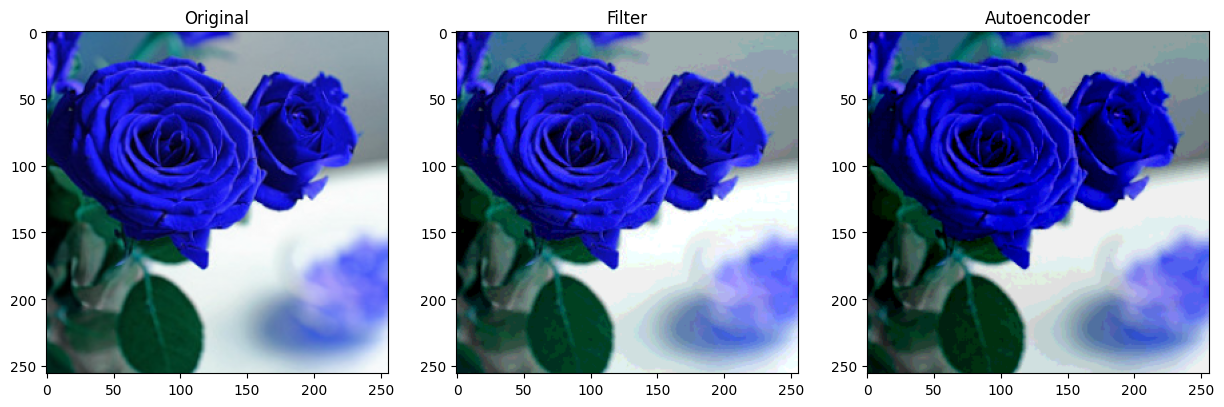

In [69]:
# plot comparison
plt.figure(figsize=(5*3, 5))
plt.subplot(1, 3, 1)
plt.imshow((x - np.min(x))/(np.max(x)-np.min(x)))
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(y)
plt.title("Filter")

plt.subplot(1, 3, 3)
plt.imshow(y_pred)
plt.title("Autoencoder")

plt.show()

In [72]:
graphdef, state = nnx.split(autoencoder)

nnx.display(graphdef, state)

NodeDef(
  type=AutoEncoder,
  index=0,
  attributes=('K', 'activation', 'compress', 'conv1a', 'conv1b', 'conv2a', 'conv2b', 'do', 'n_channels', 'outconv1a', 'outconv1b', 'outconv2a', 'outconv2b', 'outconv3', 'pool', 'upconv1', 'upconv2'),
  subgraphs={
    'compress': NodeDef(
      type=Conv,
      index=1,
      attributes=('bias', 'bias_init', 'conv_general_dilated', 'dtype', 'feature_group_count', 'in_features', 'input_dilation', 'kernel', 'kernel_dilation', 'kernel_init', 'kernel_shape', 'kernel_size', 'mask', 'out_features', 'padding', 'param_dtype', 'precision', 'strides', 'use_bias'),
      subgraphs={
        'dtype': NodeDef(
          type=NoneType,
          index=-1,
          attributes=(),
          subgraphs={},
          static_fields={},
          leaves={},
          metadata=None,
          index_mapping=None
        ),
        'kernel_shape': NodeDef(
          type=tuple,
          index=-1,
          attributes=(0, 1, 2, 3),
          subgraphs={},
          sta

In [102]:
# I'm sure there's a better way to do this but... 
n_params = 0
for s in state:
    for v in state[s]:
        try:
            n_params += np.prod(state[s][v].value.shape)
        except:
            continue

In [103]:
n_params

np.int64(196579)

In [105]:
# Save the model state
with open("models/autoencoder.pkl", "wb") as file:
    pickle.dump(state, file)